# Squidpy integration

In this notebook, we will describe some usage principles for using SpatialData with squidpy.

Let's first import some useful libraries and read in a spatialdata dataset.

You might have to install squidpy with `!pip install squidpy`.

In [1]:
from pathlib import Path

import scanpy as sc
import spatialdata as sd
import spatialdata_plot
import squidpy as sq

We chosed a Xenium dataset formatted in the spatialdata format. You will have to change the path of the zarr container

In [2]:
sdata = sd.read_zarr("./../data.zarr")
sdata

/Users/giovanni.palla/Projects/anndata/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 25778, 35416), (1, 12889, 17708), (1, 6444, 8854), (1, 3222, 4427), (1, 1611, 2213)
├── Points
│     └── 'transcripts': DataFrame with shape: (42638083, 9) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (167780, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (167780, 1) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 167780 × 313
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial': AnnData (167780, 313)
with coordinate systems:


SpatialData has a more complex structure than the spatial anndata format introduced by squidpy. Nevertheless, because it fundamentally uses AnnData as tabkle for annotating regions, 
we can directly use any tool from the scverse ecosystem (squidpy included) to perform downstream analysis.

For example, let's compute a nearest neighbor graph of the spatial coordiantes of the xenium dataset.

In [3]:
sq.gr.spatial_neighbors(sdata.table)

After that, we can cluster the cells based on gene expression profiles and compute clustering.

In [4]:
sc.pp.pca(sdata.table)
sc.pp.neighbors(sdata.table)
sc.tl.leiden(sdata.table)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


And run the neighbor enrichment analysis in squidpy.

  0%|          | 0/1000 [00:00<?, ?/s]

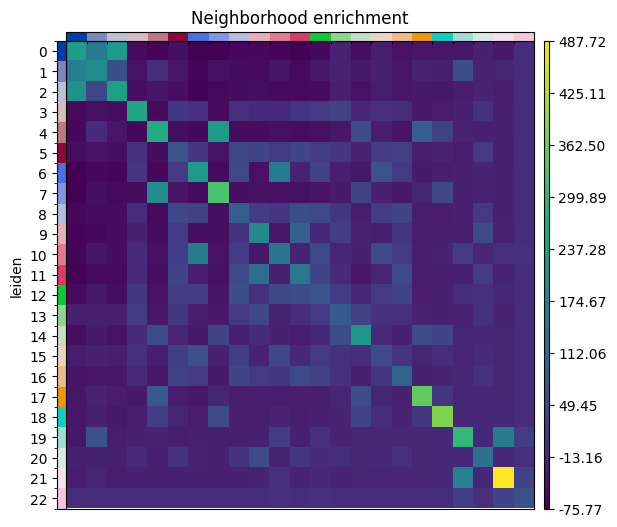

In [5]:
sq.gr.nhood_enrichment(sdata.table, cluster_key="leiden")
sq.pl.nhood_enrichment(sdata.table, cluster_key="leiden", figsize=(5, 5))

We can finally visualize the results in spatial coordinates both with squidpy as well as with the novel plotting function in spatialdata.


/Users/giovanni.palla/Projects/squidpy/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


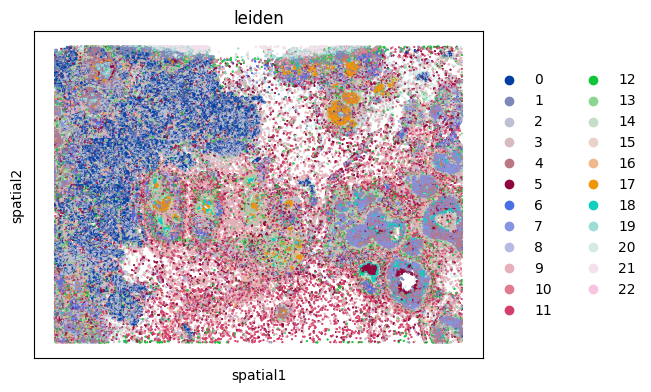

In [6]:
sq.pl.spatial_scatter(sdata.table, shape=None, color="leiden")

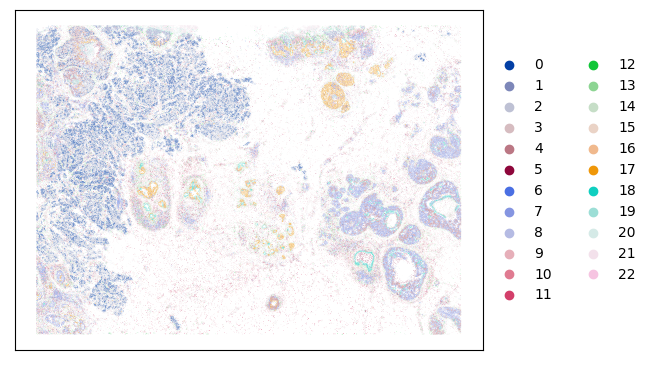

In [7]:
sdata.pl.render_shapes(element="cell_circles", color="leiden").pl.show()